In [1]:
!pip install pennylane --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 29.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import pennylane as qml
from scipy.linalg import expm

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [4]:
import os
import random

def set_seed(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [57]:
seed = 1234
set_seed(seed)

In [6]:
def Linb_meas(t_tensor):  # t_tensor: [n, 1] tensor
    t_array = t_tensor.detach().cpu().numpy().flatten()  # Convert to (n,) numpy array

    def kron3(a, b, c):
        return np.kron(np.kron(a, b), c)

    # Pauli matrices
    I0, X0, Y0, Z0 = [qml.matrix(op) for op in (qml.Identity(0), qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0))]
    I1, X1, Y1, Z1 = [qml.matrix(op) for op in (qml.Identity(1), qml.PauliX(1), qml.PauliY(1), qml.PauliZ(1))]
    I2, X2, Y2, Z2 = [qml.matrix(op) for op in (qml.Identity(2), qml.PauliX(2), qml.PauliY(2), qml.PauliZ(2))]

    # Hamiltonian parameters
    h = 2 * np.pi
    Jx = Jy = Jz = 0.1 * np.pi

    # Hamiltonian H
    H = -(h / 2) * (kron3(Z0, I1, I2) + kron3(I0, Z1, I2) + kron3(I0, I1, Z2)).astype(np.complex128)
    H -= 0.5 * Jx * (kron3(X0, X1, I2) + kron3(I0, X1, X2))
    H -= 0.5 * Jy * (kron3(Y0, Y1, I2) + kron3(I0, Y1, Y2))
    H -= 0.5 * Jz * (kron3(Z0, Z1, I2) + kron3(I0, Z1, Z2))

    # Lindblad operators
    c = np.sqrt(0.002)
    C_ops = [
        c * (kron3(X0, I1, I2) + kron3(Y0, I1, I2)),
        c * (kron3(I0, X1, I2) + kron3(I0, Y1, I2)),
        c * (kron3(I0, I1, X2) + kron3(I0, I1, Y2)),
    ]

    # Liouvillian superoperator
    dim = 8
    I_sys = np.eye(dim)
    L = -1j * (np.kron(H, I_sys) - np.kron(I_sys, H.T))
    for C in C_ops:
        CdagC = C.conj().T @ C
        L += 0.5 * (2 * np.kron(C, C.conj()) - np.kron(I_sys, CdagC.T) - np.kron(CdagC, I_sys))

    # Initial state |+00⟩
    ket_plus = (1 / np.sqrt(2)) * np.array([1, 1])
    ket_0 = np.array([1, 0])
    psi = np.kron(np.kron(ket_plus, ket_0), ket_0)
    rho0 = np.outer(psi, psi.conj())
    rho0_vec = rho0.reshape(-1)

    # Observable X on qubit 0
    X1_obs = kron3(X0, I1, I2)

    results = []
    for t in t_array:
        U = expm(L * t)
        rho_t_vec = U @ rho0_vec
        rho_t = rho_t_vec.reshape(dim, dim)
        x_t = np.real(np.trace(X1_obs @ rho_t))
        results.append(x_t)

    # Return torch tensor of shape [n, 1]
    return torch.tensor(results, dtype=torch.float32).unsqueeze(-1)


In [7]:
num_samples = 3000 # Number of samples, multiple of 5
delta = 10*math.pi / (2*3*num_samples) # Step size
n_ancilla = 3 # Number of ancilla qubits
multiplicity = 1 # Output is y = cosine(4*x)
ratio = 0.8 # Train test splitting ratio

def gen_input_seq(dataset_type, num_samples, delta, n_ancilla, multiplicity, ratio):

  # Each sequence is a 4-arithmetic progression [x0, x1, x2, x3] with step size delta
  if dataset_type == 'train':
    start = 0
    end = ratio*(10*math.pi/2) - 4*delta # Avoid train test overlapping
    steps = int(ratio*num_samples) # Take 0.8*3000 samples from 0 as training data
    x0_data = torch.linspace(start, end, steps) # Shape [num_samples, 1]
  else:
    start = ratio*(10*math.pi/2)
    end = 10*math.pi/2 - 4*delta
    steps = int((1-ratio)*num_samples)
    x0_data = torch.linspace(start, end, steps)

  x1_data = x0_data + 1 * delta
  x2_data = x0_data + 2 * delta
  x3_data = x0_data + 3 * delta

  y1_data = Linb_meas(multiplicity * x1_data.unsqueeze(-1)) # Ensure input is [num_samples, 1]
  y2_data = Linb_meas(multiplicity * x2_data.unsqueeze(-1))
  y3_data = Linb_meas(multiplicity * x3_data.unsqueeze(-1))
  target_seq = torch.cat([y1_data, y2_data, y3_data], dim=1) # Shape [num_samples, 3]


  input_seq_0 = Linb_meas(multiplicity*x0_data.unsqueeze(-1)) # Shape [num_samples, 1]
  input_seq_1 = Linb_meas(multiplicity*x1_data.unsqueeze(-1))
  input_seq_2 = Linb_meas(multiplicity*x2_data.unsqueeze(-1))

  return x0_data, input_seq_0, input_seq_1, input_seq_2, target_seq

In [8]:
x0_data_train, input_seq_0_train, input_seq_1_train, input_seq_2_train, target_seq_train = gen_input_seq(dataset_type = 'train', num_samples=num_samples, delta=delta, n_ancilla=n_ancilla, multiplicity=multiplicity, ratio=ratio)
x0_data_test, input_seq_0_test, input_seq_1_test, input_seq_2_test, target_seq_test = gen_input_seq(dataset_type = 'test', num_samples=num_samples, delta=delta, n_ancilla=n_ancilla, multiplicity=multiplicity, ratio=ratio)

In [9]:
# Cosine Dataset
class CosineDataset(Dataset):
    def __init__(self, x_0, x_1, x_2, y):
        self.x_0 = x_0
        self.x_1 = x_1
        self.x_2 = x_2
        self.y = y

    def __len__(self):
        return len(self.x_0)

    def __getitem__(self, idx):
        return self.x_0[idx], self.x_1[idx], self.x_2[idx], self.y[idx]

In [10]:
# Create dataset and dataloader
def gen_data_loader(bsz):

  train_dataset = CosineDataset(input_seq_0_train, input_seq_1_train, input_seq_2_train, target_seq_train)
  test_dataset = CosineDataset(input_seq_0_test, input_seq_1_test, input_seq_2_test, target_seq_test)

  train_loader = DataLoader(train_dataset, batch_size=bsz, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=bsz)

  return train_loader, test_loader

In [11]:
bsz = 64 # Batch size
train_loader, test_loader = gen_data_loader(bsz)

In [12]:
# Convert to numpy for plotting
x0_np = x0_data_train.numpy()
print(x0_np.shape)
y0_np = target_seq_train[:, 0].numpy()  # cos(2 * x1)
print(y0_np.shape)

(2400,)
(2400,)


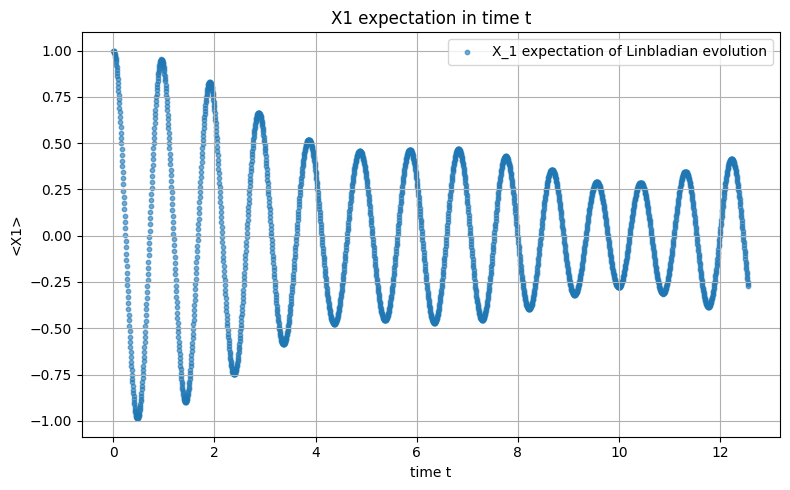

In [13]:


# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(x0_np, y0_np, label='X_1 expectation of Linbladian evolution', alpha=0.6, s=10)

plt.title("X1 expectation in time t")
plt.xlabel("time t")
plt.ylabel("<X1>")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
class RNNModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1, num_layers=1, nonlinearity='tanh'):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim,
                          hidden_size=hidden_dim,
                          num_layers=num_layers,
                          nonlinearity=nonlinearity,
                          batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self._init_weights()

    def _init_weights(self):
        # Initialize RNN weights
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.uniform_(param, a=-0.6, b=0.6)
            elif 'bias' in name:
                nn.init.zeros_(param)

        # Initialize Linear layer
        nn.init.uniform_(self.fc.weight, a=-0.6, b=0.6)
        nn.init.zeros_(self.fc.bias)


    def forward(self, x_0, x_1, x_2):

        out_0, h_0 = self.rnn(x_0)
        out_0 = self.fc(out_0)

        out_1, h_1 = self.rnn(x_1, h_0)
        out_1 = self.fc(out_1)

        out_2, _ = self.rnn(x_2, h_1)
        out_2 = self.fc(out_2)

        combined_out = torch.stack([out_0, out_1, out_2], dim=1).squeeze(-1)  # [batch_size, 3]

        return combined_out


In [69]:
model = RNNModel(input_dim=1, hidden_dim=19, output_dim=1)

In [70]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=5*1e-2)

In [71]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_params(model))

438


In [72]:
# Test random function
model.eval()
test_loss_all = 0.0
test_loss_y2 = 0.0
num_batch = 0

with torch.no_grad():
    for batch_x_0, batch_x_1, batch_x_2, batch_y in test_loader:
        output = model(batch_x_0, batch_x_1, batch_x_2)

        loss_all = criterion(output, batch_y)
        test_loss_all += loss_all.item()

        loss_y2 = criterion(output[:, 2], batch_y[:, 2]) # test only given x0 x1 x2, predict x3
        test_loss_y2 += loss_y2.item()
        num_batch += 1

    test_loss_all /= num_batch
    test_loss_y2 /= num_batch
print(f"\n Test Loss before Training (all steps): {test_loss_all:.4f}")
print(f"\n Test Loss before Training (3rd step): {test_loss_y2:.4f}")



 Test Loss before Training (all steps): 1.4250

 Test Loss before Training (3rd step): 1.5129


In [73]:
loss_history = []

In [74]:
# Training
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    num_batch = 0

    for batch_x_0, batch_x_1, batch_x_2, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x_0, batch_x_1, batch_x_2)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batch += 1
    epoch_loss /= num_batch
    #if epoch%10 == 0:
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/100 - Loss: 0.1151
Epoch 2/100 - Loss: 0.0480
Epoch 3/100 - Loss: 0.0167
Epoch 4/100 - Loss: 0.0086
Epoch 5/100 - Loss: 0.0195
Epoch 6/100 - Loss: 0.0115
Epoch 7/100 - Loss: 0.0056
Epoch 8/100 - Loss: 0.0057
Epoch 9/100 - Loss: 0.0093
Epoch 10/100 - Loss: 0.0108
Epoch 11/100 - Loss: 0.0057
Epoch 12/100 - Loss: 0.0067
Epoch 13/100 - Loss: 0.0041
Epoch 14/100 - Loss: 0.0031
Epoch 15/100 - Loss: 0.0019
Epoch 16/100 - Loss: 0.0020
Epoch 17/100 - Loss: 0.0015
Epoch 18/100 - Loss: 0.0016
Epoch 19/100 - Loss: 0.0147
Epoch 20/100 - Loss: 0.0029
Epoch 21/100 - Loss: 0.0012
Epoch 22/100 - Loss: 0.0013
Epoch 23/100 - Loss: 0.0054
Epoch 24/100 - Loss: 0.0088
Epoch 25/100 - Loss: 0.0018
Epoch 26/100 - Loss: 0.0031
Epoch 27/100 - Loss: 0.0041
Epoch 28/100 - Loss: 0.0014
Epoch 29/100 - Loss: 0.0011
Epoch 30/100 - Loss: 0.0028
Epoch 31/100 - Loss: 0.0047
Epoch 32/100 - Loss: 0.0029
Epoch 33/100 - Loss: 0.0016
Epoch 34/100 - Loss: 0.0015
Epoch 35/100 - Loss: 0.0008
Epoch 36/100 - Loss: 0.0015
E

In [76]:
#Evaluation
model.eval()
test_loss_all = 0.0
test_loss_y2 = 0.0
num_batch = 0
x_3_list = []
y_2_list = []

with torch.no_grad():
    for batch_x_0, batch_x_1, batch_x_2, batch_y in test_loader:
        output = model(batch_x_0, batch_x_1, batch_x_2)

        loss_all = criterion(output, batch_y)
        test_loss_all += loss_all.item()

        loss_y2 = criterion(output[:, 2], batch_y[:, 2])
        test_loss_y2 += loss_y2.item()

        x_3_list.append(output[:, 2].tolist())
        y_2_list.append(batch_y[:, 2].tolist())

        num_batch += 1
    test_loss_all /= num_batch
    test_loss_y2 /= num_batch
print(f"\n Final test Loss (all steps): {test_loss_all:.4f}")
print(f"\n Final test Loss (3rd step): {test_loss_y2:.4f}")


 Final test Loss (all steps): 0.0011

 Final test Loss (3rd step): 0.0010


In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [78]:
n_steps = len(loss_history)

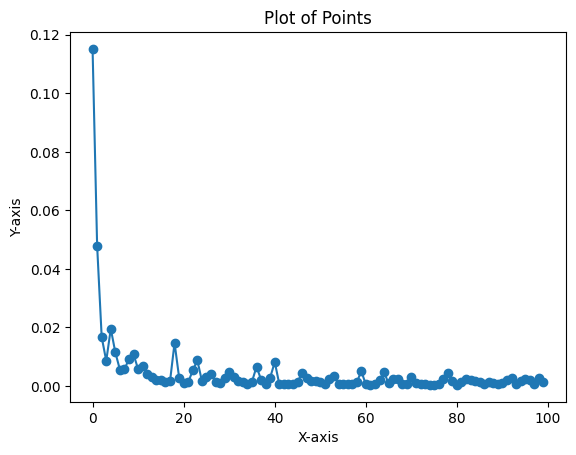

In [79]:

x_coords = [i for i in range(n_steps)]
y_coords = loss_history

plt.plot(x_coords, y_coords, c="#1f77b4", marker="o")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot of Points')
plt.show()

In [80]:
print(loss_history)

[0.11514836319379117, 0.04796265914889151, 0.01672901213169098, 0.008583471368949273, 0.01953756711200664, 0.011453616322557392, 0.005576971014593973, 0.00568461077177505, 0.009284712876634378, 0.010814179464145318, 0.005707239076544188, 0.0067432651075681575, 0.004148470608542036, 0.0031045307650377878, 0.0019005472361306218, 0.0019623170695635245, 0.001457775853372081, 0.0015703028674531531, 0.014727739396652109, 0.0028992606668524737, 0.0011955334017616942, 0.00127703214667762, 0.005352821921022903, 0.00879512439285846, 0.0017784740484785289, 0.003124903320751496, 0.004119043465164539, 0.001414930046609554, 0.0010630442120600492, 0.002756891879375632, 0.004722051778930779, 0.0029238266410845284, 0.0016182517551657696, 0.0014760056786288164, 0.0007886085199731353, 0.0014888865399897394, 0.006597772686386873, 0.0021615675949234222, 0.0006381141727998559, 0.0029016985890369766, 0.008207637776841262, 0.0006093347788249192, 0.0006291382535556821, 0.0007436017143558466, 0.0007419337359208

In [81]:
print(x_3_list)

[[-0.3262501657009125, -0.33443769812583923, -0.34790220856666565, -0.3584935963153839, -0.3695252239704132, -0.37721356749534607, -0.3865511119365692, -0.39456841349601746, -0.4036681354045868, -0.41095176339149475, -0.41824743151664734, -0.42462095618247986, -0.43085864186286926, -0.4363870918750763, -0.44163909554481506, -0.44627782702445984, -0.45050546526908875, -0.45417407155036926, -0.4573989808559418, -0.460097998380661, -0.4623299539089203, -0.464051753282547, -0.4652927815914154, -0.46602919697761536, -0.46627870202064514, -0.4660286605358124, -0.46528729796409607, -0.4640493094921112, -0.4623187482357025, -0.4600927531719208, -0.45737412571907043, -0.4541618525981903, -0.450457900762558, -0.44626131653785706, -0.44157490134239197, -0.43639805912971497, -0.430734246969223, -0.42458292841911316, -0.41794905066490173, -0.4108319580554962, -0.40323737263679504, -0.39516571164131165, -0.3866240680217743, -0.3776146471500397, -0.36814185976982117, -0.35821452736854553, -0.34783551

In [82]:
print(y_2_list)

[[-0.29611027240753174, -0.3072156608104706, -0.31795135140419006, -0.32829973101615906, -0.3382514417171478, -0.3477901816368103, -0.35690727829933167, -0.3655877411365509, -0.3738236427307129, -0.3816014528274536, -0.3889140188694, -0.3957493305206299, -0.40209993720054626, -0.40795865654945374, -0.4133158326148987, -0.4181664288043976, -0.422502338886261, -0.42631950974464417, -0.4296115040779114, -0.43237513303756714, -0.4346057176589966, -0.43630069494247437, -0.4374579191207886, -0.4380752146244049, -0.4381518065929413, -0.4376872479915619, -0.43668174743652344, -0.4351366460323334, -0.43305304646492004, -0.4304340183734894, -0.4272816479206085, -0.4236007332801819, -0.4193950891494751, -0.4146687686443329, -0.4094291627407074, -0.4036806523799896, -0.3974321782588959, -0.39068904519081116, -0.3834618330001831, -0.3757566809654236, -0.3675857484340668, -0.358955979347229, -0.34988102316856384, -0.34037041664123535, -0.3304338753223419, -0.320087194442749, -0.3093391954898834, -0.

In [83]:
file_path = 'simple_model.pth'
torch.save(model.state_dict(), file_path)

In [85]:
model1 = RNNModel(input_dim=1, hidden_dim=19, output_dim=1)
model1.load_state_dict(torch.load(file_path))
model1.eval()

RNNModel(
  (rnn): RNN(1, 19, batch_first=True)
  (fc): Linear(in_features=19, out_features=1, bias=True)
)

In [86]:
#Evaluation
model1.eval()
test_loss_all = 0.0
test_loss_y2 = 0.0
num_batch = 0
output_list = []
y_list = []

with torch.no_grad():
    for batch_x_0, batch_x_1, batch_x_2, batch_y in test_loader:
        output = model1(batch_x_0, batch_x_1, batch_x_2)

        loss_all = criterion(output, batch_y)
        test_loss_all += loss_all.item()

        loss_y2 = criterion(output[:, 2], batch_y[:, 2])
        test_loss_y2 += loss_y2.item()

        output_list.append(output.tolist())
        y_list.append(batch_y.tolist())

        num_batch += 1
    test_loss_all /= num_batch
    test_loss_y2 /= num_batch
print(f"\n Final test Loss (all steps): {test_loss_all:.4f}")
print(f"\n Final test Loss (3rd step): {test_loss_y2:.4f}")


 Final test Loss (all steps): 0.0011

 Final test Loss (3rd step): 0.0010


In [87]:
print(output_list)

[[[-0.34159231185913086, -0.3223991096019745, -0.3262501657009125], [-0.3607806861400604, -0.33090147376060486, -0.33443769812583923], [-0.4104238450527191, -0.3444272577762604, -0.34790220856666565], [-0.40840545296669006, -0.3551426827907562, -0.3584935963153839], [-0.3675541579723358, -0.36625567078590393, -0.3695252239704132], [-0.39232203364372253, -0.37416478991508484, -0.37721356749534607], [-0.37924012541770935, -0.3836279809474945, -0.3865511119365692], [-0.39260223507881165, -0.39182886481285095, -0.39456841349601746], [-0.3988712728023529, -0.401032418012619, -0.4036681354045868], [-0.4063211977481842, -0.40848878026008606, -0.41095176339149475], [-0.41232654452323914, -0.4159310758113861, -0.41824743151664734], [-0.4211309254169464, -0.42247602343559265, -0.42462095618247986], [-0.42652401328086853, -0.42886754870414734, -0.43085864186286926], [-0.4328971803188324, -0.43456360697746277, -0.4363870918750763], [-0.43812188506126404, -0.4399729073047638, -0.44163909554481506],

In [88]:
print(y_list)

[[[-0.28851553797721863, -0.2923324704170227, -0.29611027240753174], [-0.2998606264591217, -0.30355849862098694, -0.3072156608104706], [-0.31084537506103516, -0.3144194781780243, -0.31795135140419006], [-0.3214518427848816, -0.3248976469039917, -0.32829973101615906], [-0.3316704034805298, -0.3349834978580475, -0.3382514417171478], [-0.34148430824279785, -0.3446604907512665, -0.3477901816368103], [-0.35088464617729187, -0.3539198637008667, -0.35690727829933167], [-0.3598560094833374, -0.36274638772010803, -0.3655877411365509], [-0.36839020252227783, -0.3711320459842682, -0.3738236427307129], [-0.37647318840026855, -0.3790630102157593, -0.3816014528274536], [-0.3840975761413574, -0.3865320086479187, -0.3889140188694], [-0.3912508189678192, -0.3935267925262451, -0.3957493305206299], [-0.39792516827583313, -0.4000397324562073, -0.40209993720054626], [-0.4041130542755127, -0.4060634672641754, -0.40795865654945374], [-0.4098043143749237, -0.41158807277679443, -0.4133158326148987], [-0.414993